In [1]:
import pandas as pd 
import numpy as np
import os
import cv2
from tqdm import tqdm

import matplotlib.pyplot as plt

PATH = '../input/landsat8/landsat8/'

In [2]:
def extract_images_random(bands, mask, number, size = (250, 250)):
    minibands = np.empty((number, size[0], size[1], bands.shape[2]))
    masks = np.empty((number,size[0], size[1], 1))
    for k in range(number):
        while True:
            # check for correctness
            i = np.random.randint(0, bands.shape[0] - size[0])
            j = np.random.randint(0,bands.shape[1] - size[1])
            minibands[k, :, :, :] = bands[i: i + size[0], j : j + size[1], :]/255
            masks[k] = mask[i: i + size[0], j : j + size[1], :]/255
            if len(np.unique(masks[k])) > 1:
                break
    return minibands, masks

In [3]:
from keras.callbacks import *

class CyclicLR(Callback):
    
#     cl = CyclicLR(base_lr=0.0001, max_lr=0.005,
#               step_size=steps, mode = 'cosine', gamma = 0.999,
#               scale_mode='iterations', cycle_mult = 2)
    
    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=50., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle', cycle_mult = 1):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.init_max_lr = max_lr
        self.step_size = step_size
        self.slope = (base_lr - max_lr)/step_size
        self.mode = mode
        self.gamma = gamma
        self.cycle_mult = cycle_mult
        self.cycle = 0
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(1.2**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'cosine':
                self.scale_fn = lambda x: np.cos(np.pi * x / step_size)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.iterations     = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        self.iterations = 1.
        self.step_size/=(2**self.cycle)
        self.cycle = 0
        if self.mode == 'cosine':
            self.scale_fn = lambda x: np.cos(np.pi * x / self.step_size)
        if self.mode == 'triangular2':
            self.max_lr = self.init_max_lr
            
    def clr(self):
        if (self.iterations % self.step_size)==1:
            self.iterations = 1.
            self.cycle+=1
            self.step_size*=self.cycle_mult
            if self.mode == 'triangular2':
                self.max_lr *= self.scale_fn(self.cycle)
            self.slope = (self.base_lr - self.max_lr)/self.step_size
            if self.mode == 'cosine':
                self.scale_fn = lambda x: np.cos(np.pi * x / self.step_size)
        
        if self.iterations == self.step_size:
            itr = self.iterations
        else:
            itr = self.iterations % self.step_size
        if self.scale_mode == 'cycle':
            return np.maximum(self.base_lr,
                              (self.slope * itr + self.max_lr))
        else:
            A = self.max_lr - self.base_lr
            return (A/2*(self.scale_fn(self.iterations) + 1) + self.base_lr) * self.gamma**(self.clr_iterations)
                
    def on_train_begin(self, logs={}):
        logs = logs or {}
        
        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.max_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1
        self.iterations     += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())


Using TensorFlow backend.


In [4]:
import keras.backend as K
import tensorflow as tf
def castF(x):
    return K.cast(x, K.floatx())

def castB(x):
    return K.cast(x, bool)



def iou_loss_core(true,pred):  #this can be used as a loss if you make it negative
    intersection = true * pred
    notTrue = 1 - true
    union = true + (notTrue * pred)

    return (K.sum(intersection, axis=-1) + K.epsilon()) / (K.sum(union, axis=-1) + K.epsilon())


def IoU(true, pred): #any shape can go - can't be a loss function

    tresholds = [0.5 + (i*.05)  for i in range(10)]

    #flattened images (batch, pixels)
    true = K.batch_flatten(true)
    pred = K.batch_flatten(pred)
    pred = castF(K.greater(pred, 0.5))

    #total white pixels - (batch,)
    trueSum = K.sum(true, axis=-1)
    predSum = K.sum(pred, axis=-1)

    #has mask or not per image - (batch,)
    true1 = castF(K.greater(trueSum, 1))    
    pred1 = castF(K.greater(predSum, 1))

    #to get images that have mask in both true and pred
    truePositiveMask = castB(true1 * pred1)

    #separating only the possible true positives to check iou
    testTrue = tf.boolean_mask(true, truePositiveMask)
    testPred = tf.boolean_mask(pred, truePositiveMask)

    #getting iou and threshold comparisons
    iou = iou_loss_core(testTrue,testPred) 
    truePositives = [castF(K.greater(iou, tres)) for tres in tresholds]

    #mean of thressholds for true positives and total sum
    truePositives = K.mean(K.stack(truePositives, axis=-1), axis=-1)
    truePositives = K.sum(truePositives)

    #to get images that don't have mask in both true and pred
    trueNegatives = (1-true1) * (1 - pred1) # = 1 -true1 - pred1 + true1*pred1
    trueNegatives = K.sum(trueNegatives) 

    return (truePositives + trueNegatives) / castF(K.shape(true)[0])

In [5]:
nums = 150
size = (256,256)
band_n = 7 # change band numb
total_tr = nums * (len(os.listdir(PATH))- 1)
total_val = nums 
tr_bands = np.empty((total_tr, size[0], size[1], band_n))
tr_target = np.empty((total_tr, size[0], size[1], 1))

val_bands = np.empty((total_val, size[0], size[1], band_n))
val_target = np.empty((total_val, size[0], size[1], 1))

k = 0
index = 0
for value in tqdm(os.listdir(PATH)):
    if index != 5:
        path = PATH + value + '/'
        mask = cv2.imread(path + 'QB.tif')
        mask = mask[:, :, 1].reshape(mask.shape[0], mask.shape[1], 1)
        bnds = np.empty((mask.shape[0], mask.shape[1], band_n))
        for value in sorted(os.listdir(path)):
            if value.split('.')[0][0] == 'B':
                n = int(value.split('.')[0][1:])
                if n<8: 
                    bnd = cv2.imread(path + value)[:, :, 0]
                    bnds[:, :, n-1] = bnd
                    k+=1
        k = 0
        mnbands, msk = extract_images_random(bnds, mask, nums, size = size)
        tr_bands[index*nums : (index+1)*nums, :, :, :] = mnbands
        tr_target[index*nums : (index+1)*nums, :, :, :] = msk
        index += 1
    else:
        path = PATH + value + '/'
        mask = cv2.imread(path + 'QB.tif')
        mask = mask[:, :, 1].reshape(mask.shape[0], mask.shape[1], 1)
        bnds = np.empty((mask.shape[0], mask.shape[1], band_n))
        for value in sorted(os.listdir(path)):
            if value.split('.')[0][0] == 'B':
                n = int(value.split('.')[0][1:])
                if n<8: 
                    bnd = cv2.imread(path + value)[:, :, 0]
                    bnds[:, :, n-1] = bnd
                    k+=1
        k = 0
        mnbands, msk = extract_images_random(bnds, mask, nums, size = size)
        val_bands[0: nums, :, :, :] = mnbands
        val_target[0: nums, :, :, :] = msk
    %reset_selective -f mask
    %reset_selective -f bnd
    %reset_selective -f bnds
    %reset_selective -f mnbands
    %reset_selective -f msk

100%|██████████| 6/6 [00:57<00:00,  9.73s/it]


In [6]:
from keras.preprocessing.image import ImageDataGenerator
image_datagen = ImageDataGenerator(shear_range=0.5, 
                              rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, 
                             fill_mode='reflect')
mask_datagen = ImageDataGenerator(shear_range=0.5, 
                              rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, 
                             fill_mode='reflect')

seed = 2019
image_datagen.fit(tr_bands, augment = True, seed = seed)
mask_datagen.fit(tr_target, augment = True, seed = seed)

x = image_datagen.flow(tr_bands, batch_size = 16, shuffle = True, seed = seed)
y = mask_datagen.flow(tr_target, batch_size = 16, shuffle = True, seed = seed)
train_generator = zip(x,y)

/opt/conda/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:923: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (750, 256, 256, 7) (7 channels).
  ' channels).')
/opt/conda/lib/python3.6/site-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (750, 256, 256, 7) (7 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


In [7]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate

from keras import losses, optimizers, metrics

In [8]:
def create_unet():
    # U-Net model
    inputs = Input((256, 256, band_n))
    s = Lambda(lambda x: x) (inputs)

    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model_unet = Model(inputs=[inputs], outputs=[outputs])
#     model_unet.summary()
    return model_unet

In [9]:
early_stopping = EarlyStopping(monitor = 'val_binary_accuracy',
                              patience = 30,
                              verbose = 1,
                              mode = 'max')

cl = CyclicLR(base_lr=0.001, max_lr=0.01,
              step_size=5, mode = 'cosine', gamma = 0.999,
              scale_mode='iterations', cycle_mult = 2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


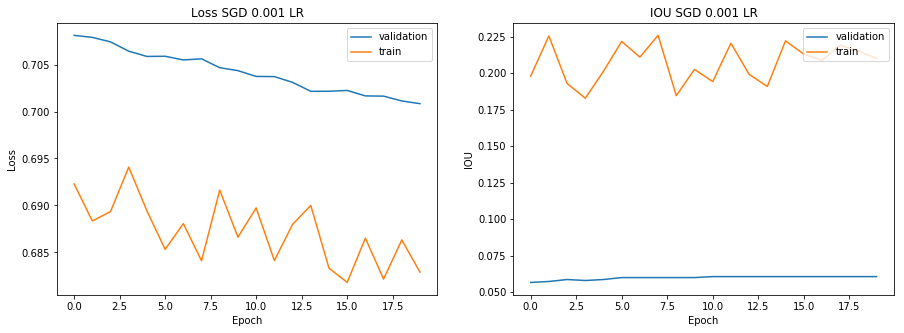

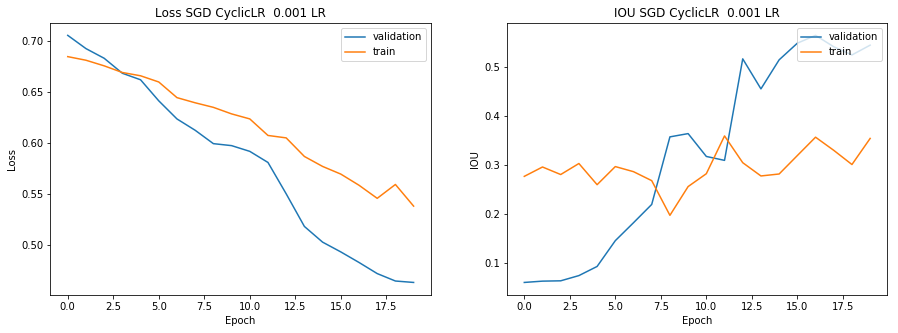

Epoch 00032: early stopping


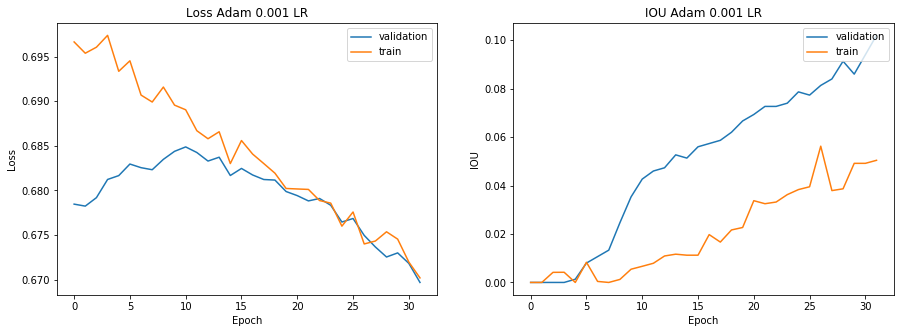

Epoch 00031: early stopping


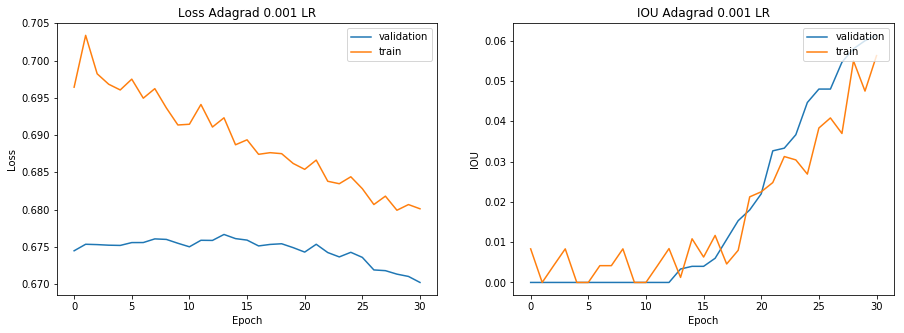

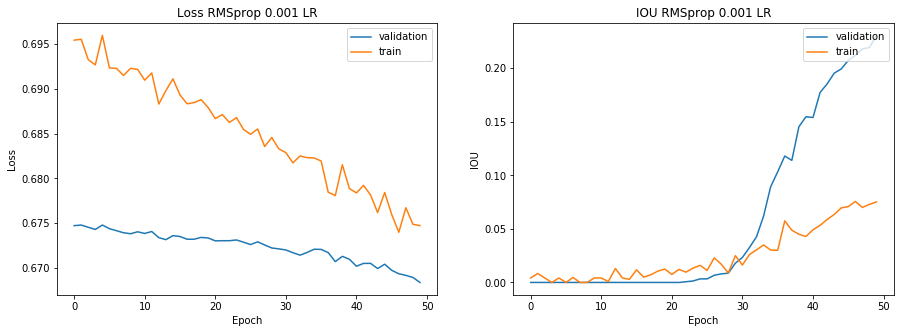

In [10]:
for optimizer in [optimizers.SGD(lr = 0.001), optimizers.Adam(lr = 0.001), optimizers.Adagrad(lr = 0.001), optimizers.RMSprop(lr = 0.001)]:
    name = str(optimizer).split('.')[-1].split(' ')[0]
    if not name == 'SGD':
        model_unet = create_unet()
        model_unet.compile(optimizer= optimizers.SGD(lr = 0.001),
                 loss = losses.binary_crossentropy,
                 metrics = [IoU, metrics.binary_accuracy])

        history_unet = model_unet.fit_generator(train_generator, 
                        epochs=50,
                        verbose=0,
                        steps_per_epoch = 15,
                        validation_data=(val_bands, val_target),
                        callbacks = [early_stopping])
        f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))
        ax1.set_title('Loss ' + name +' 0.001 LR')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.plot(history_unet.history['val_loss'], label = 'validation')
        ax1.plot(history_unet.history['loss'], label = 'train')
        ax1.legend(loc="upper right")


        ax2.set_title('IOU ' +  name +' 0.001 LR')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('IOU')
        ax2.plot(history_unet.history['val_IoU'], label = 'validation')
        ax2.plot(history_unet.history['IoU'], label = 'train')
        ax2.legend(loc="upper right")
        plt.show()
    if name == 'SGD':
        model_unet = create_unet()
        model_unet.compile(optimizer= optimizers.SGD(lr = 0.001),
                 loss = losses.binary_crossentropy,
                 metrics = [IoU, metrics.binary_accuracy])

        history_unet = model_unet.fit_generator(train_generator, 
                        epochs=20,
                        verbose=0,
                        steps_per_epoch = 15,
                        validation_data=(val_bands, val_target),
                        callbacks = [early_stopping])
        f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))
        ax1.set_title('Loss ' + name +' 0.001 LR')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.plot(history_unet.history['val_loss'], label = 'validation')
        ax1.plot(history_unet.history['loss'], label = 'train')
        ax1.legend(loc="upper right")


        ax2.set_title('IOU ' +  name +' 0.001 LR')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('IOU')
        ax2.plot(history_unet.history['val_IoU'], label = 'validation')
        ax2.plot(history_unet.history['IoU'], label = 'train')
        ax2.legend(loc="upper right")
        plt.show()
        
        model_unet = create_unet()
        model_unet.compile(optimizer= optimizers.SGD(lr = 0.001),
                 loss = losses.binary_crossentropy,
                 metrics = [IoU, metrics.binary_accuracy])

        history_unet = model_unet.fit_generator(train_generator, 
                        epochs=20,
                        verbose=0,
                        steps_per_epoch = 15,
                        validation_data=(val_bands, val_target),
                        callbacks = [early_stopping, cl])
        f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))
        ax1.set_title('Loss ' + name + ' CyclicLR ' +' 0.001 LR')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.plot(history_unet.history['val_loss'], label = 'validation')
        ax1.plot(history_unet.history['loss'], label = 'train')
        ax1.legend(loc="upper right")


        ax2.set_title('IOU ' +  name + ' CyclicLR ' +' 0.001 LR')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('IOU')
        ax2.plot(history_unet.history['val_IoU'], label = 'validation')
        ax2.plot(history_unet.history['IoU'], label = 'train')
        ax2.legend(loc="upper right")
        plt.show()
        
        